In [1]:
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.loaders import BaseShockSlowInteractionsLoader
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.io import load_neurons, load_derived_generic
import seaborn as sns
import pandas as pd
import numpy as np
from drn_interactions.interactions.graph_clustering import SpectralCluster, ClusterRunner, ClusterEvaluation, ClusterResults
import warnings
from drn_interactions.config import Config, ExperimentInfo
from tqdm import tqdm

dd = Config.derived_data_dir / "ensembles"
dd.mkdir(exist_ok=True)
sns.set_theme(style="ticks", context="paper")

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sessions = ExperimentInfo.foot_shock_sessions_10min

preprocessor = InteractionsPreprocessor(z=True, minmax=False)
evaluator = ClusterEvaluation()

loader_fac = lambda session, block, bin_width: BaseShockSlowInteractionsLoader(
    session_name=session, block=block, bin_width=bin_width,
)
corr_fac = lambda: PairwiseCorr(
    remove_self_interactions=True,
    rectify=True,
    shuffle=False,
    remove_duplicate_combs=True,
)
cluster_fac = lambda: SpectralCluster(
    n_clusters=np.arange(2, 8), spectral_kws={"affinity": "precomputed"}, n_init=3
)

runner_fac = lambda session, block, bin_width: ClusterRunner(
    loader=loader_fac(session=session, block=block, bin_width=bin_width),
    preprocessor=preprocessor,
    affinity_calculator=corr_fac(),
    clusterer=cluster_fac(),
    evalulator=evaluator,
)

In [4]:
ensemble_frames = []
ensemble_stats_frames = []

for bin_width in (0.05, 0.1, 0.5, 1):
    for block in ("pre", "base_shock"):
        for session in tqdm(sessions):

            # calculate ensembles
            runner = runner_fac(session=session, block=block, bin_width=bin_width)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    _, ensembles, _, ensemble_stats = runner.run(10)
                except ValueError as e:
                    print(e)
                    print(session)

            # add metadata and append to list of results
            ensembles = ensembles.assign(session_name=session, block=block, bin_width=bin_width)
            ensemble_stats = ensemble_stats.assign(session_name=session, block=block, bin_width=bin_width)
            ensemble_stats_frames.append(ensemble_stats)
            ensemble_frames.append(ensembles)

df_ensembles = pd.concat(ensemble_frames).reset_index(drop=True)
df_ensembles_stats = pd.concat(ensemble_stats_frames).reset_index(drop=True)

df_ensembles_stats["ensemble_id"] = pd.factorize(
    df_ensembles_stats["ensemble"].astype(str)
    + df_ensembles_stats["session_name"]
    + df_ensembles_stats["block"]
    + df_ensembles_stats["bin_width"].astype(str)
)[0]
df_ensembles_stats["ensemble_id"] = np.where(
    df_ensembles_stats["ensemble"] == -1,
    -1,
    df_ensembles_stats["ensemble_id"],
)
df_ensembles = (
    df_ensembles.merge(
    df_ensembles_stats[["session_name", "ensemble", "ensemble_id", "block", "bin_width"]],
    on=["session_name", "ensemble", "block", "bin_width"]
    )
)

df_ensembles.to_csv(dd / "fs - ensembles.csv", index=False)
df_ensembles_stats.to_csv(dd / "fs - stats.csv", index=False)


 62%|██████▎   | 5/8 [01:14<00:39, 13.11s/it]

attempt to get argmax of an empty sequence
hamilton_37


 62%|██████▎   | 5/8 [01:05<00:34, 11.59s/it]

attempt to get argmax of an empty sequence
hamilton_37


 62%|██████▎   | 5/8 [00:55<00:29,  9.74s/it]

attempt to get argmax of an empty sequence
hamilton_37


 62%|██████▎   | 5/8 [00:53<00:27,  9.33s/it]

attempt to get argmax of an empty sequence
hamilton_37


100%|██████████| 8/8 [01:52<00:00, 14.00s/it]


### Ensemble Properties

Are the properties of ensembles different between the two states?

Properties:
- Size
- Average Weight
- Average Conductivity
- Edge Expantion


size
 n_pre         15.00
n_shock       17.00
Mean_pre      13.07
Mean_shock     8.71
Diff          -4.36
U             98.50
p              0.14
dtype: float64

average_weight
 n_pre          15.00
n_shock        17.00
Mean_pre        0.25
Mean_shock      0.25
Diff           -0.00
U             118.00
p               0.37
dtype: float64

conductance
 n_pre         15.00
n_shock       17.00
Mean_pre       0.52
Mean_shock     0.38
Diff          -0.14
U             78.00
p              0.03
dtype: float64


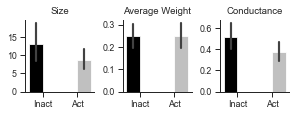

In [6]:
from drn_interactions.stats import mannwhitneyu_plusplus
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK

def compare_metric(df, metric):
    x = df.query("ensemble_id != -1 and block == 'pre'")[metric].values
    y = df.query("ensemble_id != -1 and block == 'base_shock'")[metric].values
    return mannwhitneyu_plusplus(x, y, names=("pre", "shock")).round(2)

def plot_metric(df, metric, ax, **kwargs):
    return (
        df
        .query("ensemble_id != -1")
        .pipe((sns.barplot, "data"), x="block", y=metric, hue="block", ax=ax, **kwargs)
    )


df_stats = df_ensembles_stats.query("bin_width == 1")

f = plt.figure(figsize=(4, 1.5), constrained_layout=True)
axes = f.subplots(1, 3, sharex=True)

for i, (metric, lab, ylab) in enumerate(zip(
    ("size", "average_weight", "conductance"), 
    ("Size", "Average Weight", "Conductance"),
    ("", "", r""),
    )):
    res = compare_metric(df_stats, metric)
    print(f"\n{metric}\n", res)
    ax = axes[i]
    plot_metric(df_stats, metric, ax, palette=PAL_GREY_BLACK)
    ax.legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(ylab)
    ax.set_title(lab)
    ax.set_xticklabels(["Inact", "Act"])

sns.despine(fig=f)
    

In [7]:
df_ensembles

,neuron_id,ensemble,sig,ensemble_orig,session_name,block,bin_width,ensemble_id
0,1031,-1,False,0,hamilton_04,pre,0.05,-1
1,1031,-1,False,0,hamilton_04,pre,0.05,-1
2,1031,-1,False,0,hamilton_04,pre,0.05,-1
3,1035,-1,False,0,hamilton_04,pre,0.05,-1
4,1035,-1,False,0,hamilton_04,pre,0.05,-1
...,...,...,...,...,...,...,...,...
5383,1961,-1,False,2,hamilton_32,base_shock,1.00,-1
5384,1961,-1,False,2,hamilton_32,base_shock,1.00,-1
5385,1975,3,True,3,hamilton_32,base_shock,1.00,126
5386,1973,3,True,3,hamilton_32,base_shock,1.00,126


Text(0.5, 1.0, 'Number of Ensembles')

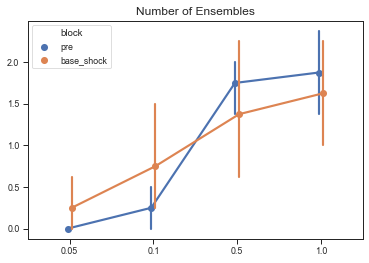

In [14]:
dfp = (
    df_ensembles   
    .groupby(["session_name", "block", "bin_width"])
    ["ensemble_id"]
    .nunique()
    .subtract(1)
    .to_frame("Number of Ensembles")
    .reset_index()
)

_, ax = plt.subplots()
sns.pointplot(
    x="bin_width",
    y="Number of Ensembles",
    hue="block",
    data=dfp,
    estimator=np.mean,
    ax=ax,
    dodge=True,
    hue_order=["pre", "base_shock"]
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Number of Ensembles", fontsize=12)